837it [00:12, 65.54it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] 

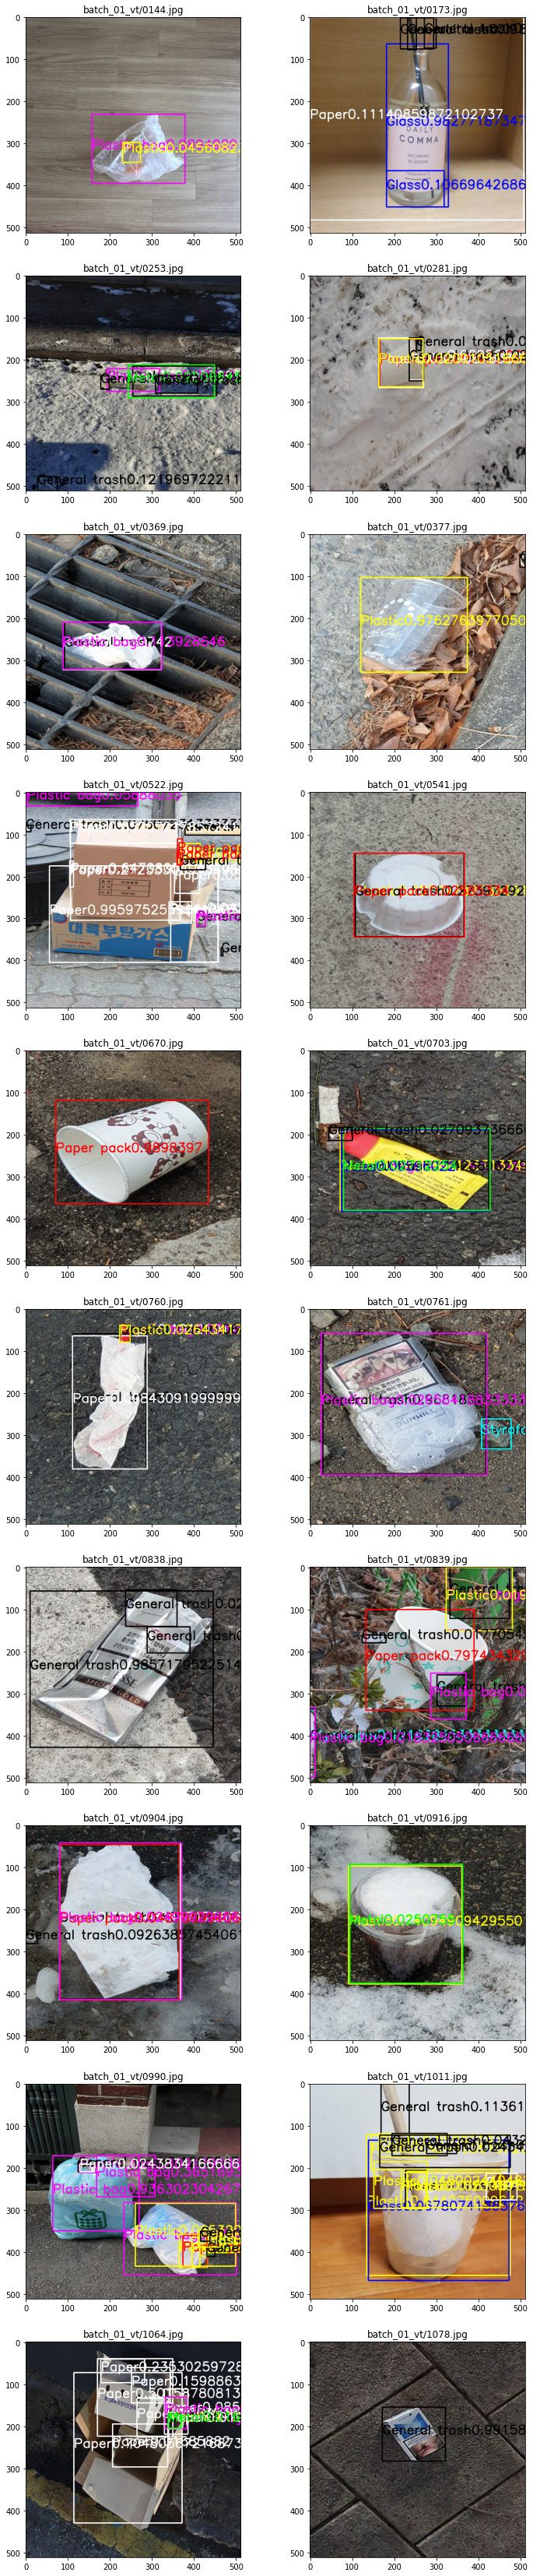

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm


###########################Set directories############################

data_dir = '/opt/ml/input/data'
sub_dir = 'submissions/before_ensemble'

rows, cols = 10, 2 #images to show

###########################Set directories############################

dataframes = []
for file_name in os.listdir(sub_dir):
    if '.ip' in file_name:
        continue
    dataframes.append(pd.read_csv(os.path.join(sub_dir, file_name)))

colors = [0,(0,0,0),(255,255,255), (255,0,0),(0,255,0),(0,0,255),(255,255,0),(0,255,255), (255,0,255), (192,192,192), (128,128,128), (128,0,0)]


labels = ("UNKNOWN", "General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")


def _draw_rectangle(image, label, score, y, x, height, width):
    cv2.rectangle(image, (y, x), (y+height, x+width), colors[label], 2)
    cv2.putText(image, f'{labels[label]}{score}', (y, x+width//2), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, colors[label], 2)
    return image


def draw_rectangle(image, bboxes):
    # bboxes = sorted(bboxes, key=lambda x:x[2], reverse=True)[:10]
    for bbox in bboxes:
        label, score, y, x, height, width = bbox
        image = _draw_rectangle(image, label, score, y, x, height, width)
    
    return image


def get_bbox(PredictionString):
    bboxes = []
    PredictionString = PredictionString.split()
    for i in range(0, len(PredictionString), 6):
        label, score, y, x, yy, xx =  map(float, PredictionString[i:i+6])
        y = int(y)
        x = int(x)
        height = int(yy) - y
        width = int(xx) - x
        label = int(label)
        bboxes.append((label, score, y, x, height, width))
    return bboxes


def load_image(image_dir):
    image = cv2.imread(image_dir)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float64)
    return image/255


def show_image(images, row=10, col=2):
    fig = plt.figure(figsize=(12, 60))

    idx = 1

    for r in range(1, row+1):
        for c in range(1, col+1):
            image, image_id = images[r*row+c]
            ax = fig.add_subplot(row,col,idx)
            ax.imshow(image)
            ax.set_title(image_id)
            idx += 1
    plt.show()

df = pd.read_csv('/opt/ml/code/mmdetection_trash/submissions/wbf_kyubin.csv')


images = []
cnt_bbox = []

for row in tqdm(df.iterrows()):
    _, row = row
    PredictionString, image_id = row['PredictionString'], row['image_id']
    path = os.path.join(data_dir, image_id)
    image = load_image(path)
    bboxes = get_bbox(PredictionString)
    cnt_bbox.append(len(bboxes))
    images.append((draw_rectangle(image, bboxes), image_id))


show_image(images,rows,cols)

In [18]:
df = dataframes[0]

images = []
cnt_bbox = []
scores = []
for row in tqdm(df.iterrows()):
    _, row = row
    PredictionString, image_id = row['PredictionString'], row['image_id']
    scores.extend( [float(item) for idx, item in enumerate(PredictionString.split()) if idx % 6 == 1])

    # path = os.path.join(data_dir, image_id)
    # image = load_image(path)
    # bboxes = get_bbox(PredictionString)
    # cnt_bbox.append(len(bboxes))
    # images.append((draw_rectangle(image, bboxes), image_id))

837it [00:00, 8607.68it/s]


In [19]:
from collections import defaultdict
cnt_dict = defaultdict(int)

def divclass(score):
    if score > 0.9:
        cnt_dict[0.9] += 1
    elif score > 0.8:
        cnt_dict[0.8] += 1
    elif score > 0.7:
        cnt_dict[0.7] += 1
    elif score > 0.6:
        cnt_dict[0.6] += 1
    elif score > 0.5:
        cnt_dict[0.5] += 1
    elif score > 0.4:
        cnt_dict[0.4] += 1
    elif score > 0.3:
        cnt_dict[0.3] += 1
    elif score > 0.2:
        cnt_dict[0.2] += 1
    elif score > 0.1:
        cnt_dict[0.1] += 1
    else:
        cnt_dict[0] += 1
    
for score in scores:
    divclass(score)
x, y = zip(*sorted(cnt_dict.items()))

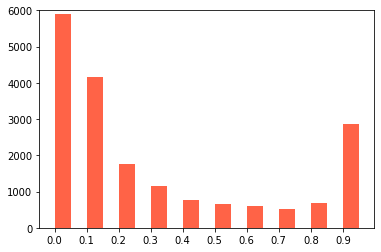

In [20]:
import matplotlib.pyplot as plt
import numpy as np


plt.bar(x, y, width=0.05, align='edge', color="tomato",
         linewidth=3, log=False)
plt.yticks(range(0,6001,1000), list(map(str, range(0, 6001, 1000))))
plt.xticks([i/10 for i in range(10)])
plt.ylim(0, 6001)
plt.show()